<a href="https://colab.research.google.com/github/NUELBUNDI/PDS_PROJECT/blob/main/PDS_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
%matplotlib inline
from bokeh.io import output_notebook
from bokeh import models, palettes, transform
from bokeh.plotting import figure, show
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import cluster, decomposition, pipeline, preprocessing
import statsmodels
import missingno as mn

In [157]:
# Read csv File.

df= pd.read_csv("https://raw.githubusercontent.com/NUELBUNDI/PDS_PROJECT/main/Salesdata.csv",encoding="Latin-1")

# **SECTION 1 : CLEANING DATA**

In [167]:
# read first five rows
df.head(2)

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.0,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.9,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2


In [168]:
# Convert the Columns to lower case and Remove spaces  Ease with uniform case.
df.columns=df.columns.str.lower()
df.columns=df.columns.str.replace(' ','')
df.columns

Index(['ordernumber', 'quantityordered', 'priceeach', 'orderlinenumber',
       'sales', 'orderdate', 'ordermonth', 'orderyear', 'status', 'qtr_id',
       'productline', 'msrp', 'productcode', 'customername', 'phone',
       'addressline1', 'city', 'state', 'postalcode', 'country',
       'contactlastname', 'contactfirstname', 'dealsize', 'quarters'],
      dtype='object')

In [169]:
# Remove $ and ,

# Create a function 
def convert(x):
  if isinstance(x, str):
    return(x.replace('$', '').replace(',', ''))
  return(x)
  
# Apply the function.

df['priceeach']=df['priceeach'].apply(lambda x: convert(x)).astype(float)
df['sales']=df['sales'].apply(lambda x: convert(x)).astype(float)
df.head(3)


,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.00,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.90,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2
2,10134,41,94.74,2,3884.34,2003-07-01,7,2003,Shipped,3,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,NaN,75508,France,Da Cunha,Daniel,Medium,Q3


In [170]:
# convert order date to pd date time frame and  create a  new month and year colum

df['orderdate']=pd.to_datetime(df['orderdate'])
df['ordermonth']=df['orderdate'].dt.month
df['orderyear']=df['orderdate'].dt.year

df.head(2)


,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.0,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.9,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2


In [171]:
# Arrange dataframe columns

cols=list(df.columns.values)

df=df[['ordernumber', 'quantityordered','priceeach', 'orderlinenumber', 'sales', 'orderdate','ordermonth','orderyear','status', 'qtr_id', 'productline', 'msrp', 'productcode', 'customername','phone', 'addressline1', 'city', 'state', 'postalcode', 'country', 'contactlastname', 'contactfirstname', 'dealsize']]


In [172]:
df['quarters']=df['ordermonth'].apply(lambda x :'Q1' if x<=3 else('Q2' if (x>3 and x<=6) else ('Q3' if (x>6 and x<=8) else 'Q4')))
df.head(4)

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,ordermonth,orderyear,status,qtr_id,productline,msrp,productcode,customername,phone,addressline1,city,state,postalcode,country,contactlastname,contactfirstname,dealsize,quarters
0,10107,30,95.70,2,2871.00,2003-02-24,2,2003,Shipped,1,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,NY,10022,USA,Yu,Kwai,Small,Q1
1,10121,34,81.35,5,2765.90,2003-05-07,5,2003,Shipped,2,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,NaN,51100,France,Henriot,Paul,Small,Q2
2,10134,41,94.74,2,3884.34,2003-07-01,7,2003,Shipped,3,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,NaN,75508,France,Da Cunha,Daniel,Medium,Q3
3,10145,45,83.26,6,3746.70,2003-08-25,8,2003,Shipped,3,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,CA,90003,USA,Young,Julie,Medium,Q3


In [173]:
print(f' The Shape of the Dataframe is in Rows and Columns respectively as  {df.shape}')

 The Shape of the Dataframe is in Rows and Columns respectively as  (2823, 24)


In [174]:
# Check for the Missing Values as value of Mean Percentage per rows so as to evaluate their relevance 

d_types=df.dtypes
d_missing=df.isnull().mean().round(4)*100

# converting to data frames

details1=pd.DataFrame(d_types,columns=['DTYPE'])
details2=pd.DataFrame(d_missing,columns=['MISSING'])

# Combine the dataframes
combine_df=pd.concat([details1,details2],axis=1)
combine_df.sort_values(by='MISSING',ascending=False)


,DTYPE,MISSING
state,object,52.64
postalcode,object,2.69
ordernumber,int64,0.00
quantityordered,int64,0.00
dealsize,object,0.00
contactfirstname,object,0.00
contactlastname,object,0.00
country,object,0.00
city,object,0.00
addressline1,object,0.00


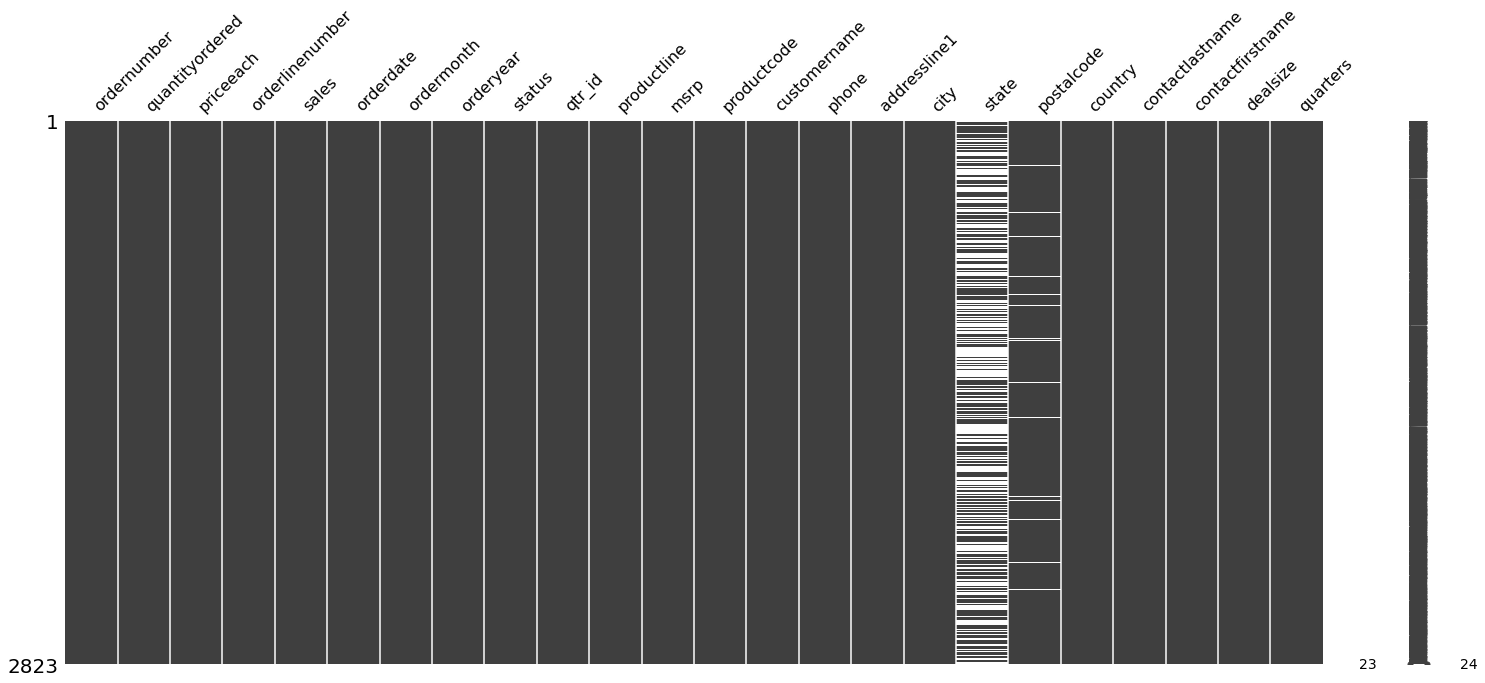

In [175]:
#Visualize the missing values

mn.matrix(df)

## **EXPLORATORY DATA ANALYSIS**